In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

import torch
from torch import nn
from torchvision import models, transforms

## Utility functions

In [2]:
# Opens image from disk, normalizes it and converts to tensor
read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    lambda x: x.convert('RGB'),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    lambda x: torch.unsqueeze(x, 0)
])

In [3]:
class Flatten(nn.Module):
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

In [4]:
# Given label number returns class name
def get_class_name(c):
    labels = np.loadtxt('stuff/synset_words.txt', str, delimiter='\t')
    return ' '.join(labels[c].split(',')[0].split()[1:])

## Load model
Here model is split into two parts: feature extractor and classifier. For architechtures other than ResNet or VGG you need to implement it yourself.
Here, `Flatten` layer is being built in in the model as well. In PyTorch implementation flattenning is done in the forward pass, but we need it as a separate layer.

In [5]:
#model = models.vgg16(pretrained=True)
model = models.resnet50(pretrained=True)

arch = model.__class__.__name__
if arch == 'ResNet':
    # Split model in two parts
    features_fn = nn.Sequential(*list(model.children())[:-2])
    classifier_fn = nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()] + list(model.children())[-1:]))
elif arch == 'VGG':
    features_fn = model.features
    classifier_fn = nn.Sequential(*([Flatten()] + list(model.classifier.children())))
    
model = model.eval()
model = model.cuda()

## Grad-CAM

In [6]:
def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.cuda())
    _, N, H, W = feats.size()
    out = classifier_fn(feats)
    c_score = out[0, c]
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W)
    return sal.cpu().detach().numpy()

## Example

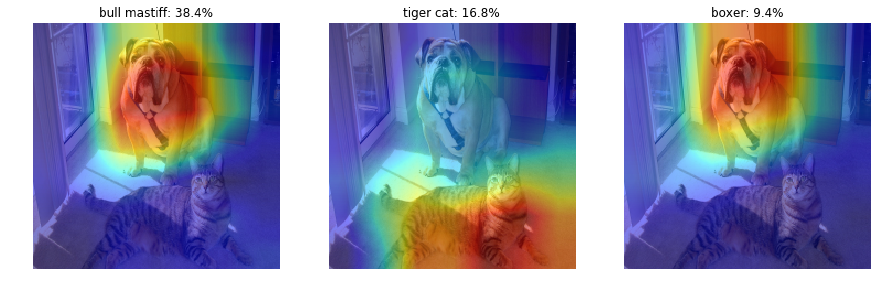

In [7]:
img_path = 'stuff/catdog.png'
img_tensor = read_tensor(img_path)
pp, cc = torch.topk(nn.Softmax(dim=1)(model(img_tensor.cuda())), 3)

plt.figure(figsize=(15, 5))
for i, (p, c) in enumerate(zip(pp[0], cc[0])):
    plt.subplot(1, 3, i+1)
    sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
    img = Image.open(img_path)
    sal = Image.fromarray(sal)
    sal = sal.resize(img.size, resample=Image.LINEAR)

    plt.title('{}: {:.1f}%'.format(get_class_name(c), 100*float(p)))
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(np.array(sal), alpha=0.5, cmap='jet')
plt.show()